In [9]:
SAMPLES = 1000
NOISE = 0.1

[[ 1.82676725  0.33932409]
 [ 0.85740015  0.66164212]
 [ 1.23344155 -0.46903851]
 ...
 [ 1.15215823 -0.59510224]
 [ 0.37129523  0.8147125 ]
 [ 1.82605617 -0.18494499]]


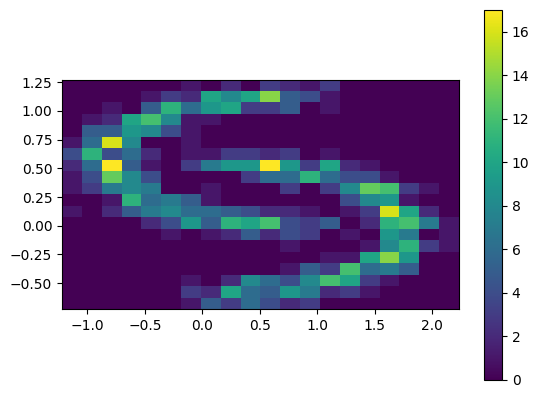

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate the data
X, _ = make_moons(n_samples=SAMPLES, noise=NOISE)

# Create a 2D histogram
hist, x_edges, y_edges = np.histogram2d(X[:, 0], X[:, 1], bins=20)

# Visualize the histogram
plt.imshow(hist, interpolation='nearest', origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
plt.colorbar()
plt.show()

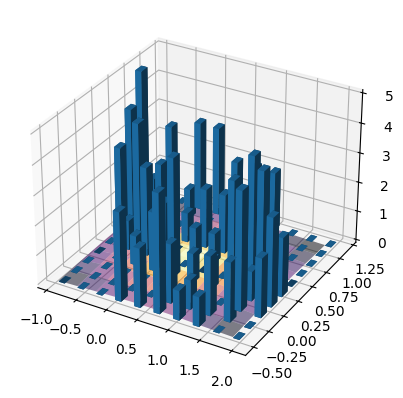

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

# Generate the data
X, _ = make_moons(n_samples=100, noise=0.1)

# Create a 3D histogram
hist, x_edges, y_edges = np.histogram2d(X[:, 0], X[:, 1], bins=10)
x_edges = (x_edges[:-1] + x_edges[1:]) / 2
y_edges = (y_edges[:-1] + y_edges[1:]) / 2
x, y = np.meshgrid(x_edges, y_edges)

# Fit a Gaussian to the histogram data
x_mean = np.mean(X[:, 0])
x_std = np.std(X[:, 0])
y_mean = np.mean(X[:, 1])
y_std = np.std(X[:, 1])
pdf = norm.pdf(x, loc=x_mean, scale=x_std) * norm.pdf(y, loc=y_mean, scale=y_std)

# Normalize the histogram
hist = hist / hist.sum()

# Visualize the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(x.ravel(), y.ravel(), np.zeros_like(hist).ravel(), 0.1, 0.1, hist.ravel(), shade=True)
ax.plot_surface(x, y, pdf, cmap='inferno', alpha=0.5)

plt.show()


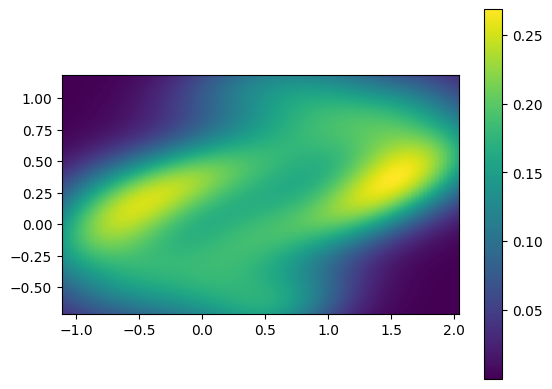

In [7]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Fit a KDE with squared exponential kernel to the data
kde = gaussian_kde(X.T, bw_method="silverman")

# Create a grid of points for visualization
x, y = np.mgrid[X[:,0].min():X[:,0].max():100j, X[:,1].min():X[:,1].max():100j]
positions = np.vstack([x.ravel(), y.ravel()])

# Evaluate the KDE on the grid
density = kde(positions)

# Visualize the KDE
plt.imshow(density.reshape(x.shape), extent=[X[:,0].min(), X[:,0].max(), X[:,1].min(), X[:,1].max()])
plt.colorbar()
plt.show()